# Advanced Fishing

This Notebook goes through some of the slightly more advanced tasks which can be performed with `GoFish`.

## Checking Disk Center

If you don't have a strong line detection, it's hard to make sure that your image is centered. We can use the `find_center` function to apply a brute force approach to finding the optimum location. This will cycle through a grid of `x0` and `y0` values and calculate the signal-to-noise ratio (SNR) of the resulting spectrum averaged over the provided parameters.

We can set the offset in the x- and y-direction considered, `dx` and `dy`, respectively, as well as the number of samples along each axis, `Nx` and `Ny`. By default we search up to a distance of the beam FWHM, sampling roughly every pixel.

We must also then consider how to calculate the noise, either on the averaged spectrum, `spectrum='avg'`, or on the integrated spectrum, `spectrum='int'`, and then whether to consider the signal the peak of that spectrum, `SNR='peak'`, or the integrated value, `SNR='int'`. By default we use the integrated flux density of the average spectrum.

A mask is also needed, defining the regions where we calculate the signal, and the regions where to calculate the noise (we use the standard deviation of the masked pixels). By default the mask assumes the line emission is in the center 20\% of the channels.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from gofish.gofish.gofish import imagecube  # change this!

In [2]:
cube = imagecube('/Users/rteague/Projects/N2Hp/data/TWHya_N2Hp_43.fits')  # need to find an appropriate example

Peak SNR at (x0, y0) = (0.42", 0.26").


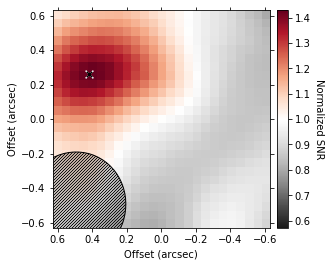

In [3]:
x0s, y0s, SNR = cube.find_center(r_min=0.5, r_max=1.0, inc=5.0, PA=152.,
                                 mstar=0.88, dist=59.5, dr_bin=0.1, resample=50.0)

What's plotted here is the SNR relative to the value at the image center, and in the bottom left corner, the synthesized beam as a size reference.

To check that this is a reasonable offset, we compare the averaged spectra at the center location and the offset.

(1840.0, 3840.0)

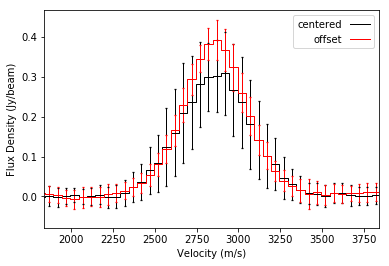

In [10]:
fig, ax = plt.subplots()

x, y, dy = cube.average_spectrum(r_min=0.5, r_max=1.0, inc=5.0, PA=152.,
                                 mstar=0.88, dist=59.5, dr_bin=0.1, resample=50.0)
ax.errorbar(x, y, dy, fmt=' ', lw=1.0, color='k', capsize=1.25, capthick=1.25)
ax.step(x, y, where='mid', color='k', lw=1.0, label='centered')

x, y, dy = cube.average_spectrum(x0=0.42, y0=0.26, r_min=0.5, r_max=1.0, inc=5.0, PA=152.,
                                 mstar=0.88, dist=59.5, dr_bin=0.1, resample=50.0)
ax.errorbar(x, y, dy, fmt=' ', lw=1.0, color='r', capsize=1.25, capthick=1.25)
ax.step(x, y, where='mid', color='r', lw=1.0, label='offset')
ax.legend(markerfirst=False)
ax.set_ylabel('Flux Density (Jy/beam)')
ax.set_xlabel('Velocity (m/s)')
ax.set_xlim(1.84e3, 3.84e3)

Clearly the offset spectrum looks a lot better, as expected!